# Surface Mass Balance: Time Series 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

Set WD

In [3]:
import os
from pyrsistent import v
os.getcwd()
os.chdir('/Users/asgerlyngeholst-hansen/Desktop/Thesis/GEUS-Master-Thesis')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

#### Load KM_L 

In [14]:
df = pd.read_csv('data/KAN_L.csv')

# add headers
header = pd.read_csv('metadata/promice_header.csv', sep = ";")
df = df.rename(columns = header.set_index('standard_name')['units']) # Headers are shifted in csv file

# add delta column 
df['Surface height from combined measurements DELTA'] = df['Surface height from combined measurements'].diff()

In [15]:
# This bit to add a beginning, middle & end of melting season attribute
beginning = 0.2
end = 0.8

# Iterate over each year
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d %H:%M:%S")

for year in df['Datetime'].dt.year.unique():
    
    print("Calculating" , year)
    
    # Get the dataframe for the current year
    year_df = df[df['Datetime'].dt.year == year]
    
    # Determine the threshold values for the beginning and end of the melting season
    ablation_df = year_df[year_df['Ablation'] == True]
    lower_threshold = ablation_df['Datetime'].dt.dayofyear.quantile(beginning)
    upper_threshold = ablation_df['Datetime'].dt.dayofyear.quantile(end)
    
    # Set the Melting Season value for each row in the current year
    for index, row in year_df.iterrows():
        
        if row['Ablation'] == True:
            if row['Datetime'].dayofyear <= lower_threshold:
                df.loc[index, 'Melting Season'] = 'beginning'
            elif row['Datetime'].dayofyear >= upper_threshold:
                df.loc[index, 'Melting Season'] = 'end'
            else:
                df.loc[index, 'Melting Season'] = 'middle'
        else:
            df.loc[index, 'Melting Season'] = ''

Calculating 2008
Calculating 2009
Calculating 2010
Calculating 2011
Calculating 2012
Calculating 2013
Calculating 2014
Calculating 2015
Calculating 2016
Calculating 2017
Calculating 2018
Calculating 2019
Calculating 2020
Calculating 2021
Calculating 2022
Calculating 2023


# Time Series

##### Pre-processing

In [16]:
# This bit to only focus on the time where we see Ice Ablation
df = df[df["Ablation"] == True]

In [17]:
# This bit to include only relevant features
exclude_list = [                                                    'index', # excluded because of unimportant information
                                                                     'stid', # excluded because of unimportant information
#                                                'Air pressure (upper boom)',
#                                             'Air temperature (upper boom)',
                                            'Relative humidity (upper boom)', # excluded because of corrected feature
#                               'Relative humidity (upper boom) - corrected',
#                                           'Specific humidity (upper boom)',
#                                                  'Wind speed (upper boom)',
#                                         'Wind from direction (upper boom)',
                                          'Downwelling shortwave radiation', # excluded because of corrected feature
#                              'Downwelling shortwave radiation - corrected',
                                            'Upwelling shortwave radiation', # excluded because of corrected feature
#                                'Upwelling shortwave radiation - corrected',
                                                                   'Albedo', # excluded due to missing values
#                                           'Downwelling longwave radiation',
#                                             'Upwelling longwave radiation',
#                                                              'Cloud cover',
#                                                      'Surface temperature',
                                            'Latent heat flux (upper boom)', # excluded due to missing values
                                          'Sensible heat flux (upper boom)', # excluded due to missing values
                                                        'Upper boom height', # excluded because of unimportant information
                                                             'Stake height', # excluded due to missing values
                                      'Depth of pressure transducer in ice', # excluded due to derived correlation with y
                          'Depth of pressure transducer in ice - corrected', # excluded due to derived correlation with y
                   'Precipitation (upper boom) (cumulative solid & liquid)', # excluded because of corrected feature
#       'Precipitation (upper boom) (cumulative solid & liquid) – corrected',
                                              'Ice temperature at sensor 1', # excluded due to missing values
                                              'Ice temperature at sensor 2', # excluded due to missing values
                                              'Ice temperature at sensor 3', # excluded due to missing values
                                              'Ice temperature at sensor 4', # excluded due to missing values
                                              'Ice temperature at sensor 5', # excluded due to missing values
                                              'Ice temperature at sensor 6', # excluded due to missing values
                                              'Ice temperature at sensor 7', # excluded due to missing values
                                              'Ice temperature at sensor 8', # excluded due to missing values
                                                             'Tilt to east', # excluded because of unimportant information 
                                                            'Tilt to north', # excluded because of unimportant information
                                         'Station rotation from true North', # excluded because of unimportant information
                                                                 'Latitude', # excluded because of unimportant information
                                                                'Longitude', # excluded because of unimportant information
                                                                 'Altitude', # excluded because of unimportant information
                                                                 'GPS time', # excluded because of unimportant information 
                               'Height of EGM96 geoid over WGS84 ellipsoid', # excluded because of unimportant information
                                                                  'GeoUnit', # excluded because of unimportant information
                             'GPS horizontal dillution of precision (HDOP)', # excluded because of unimportant information
                                                 'GPS number of satellites', # excluded because of unimportant information
                                                                  'Quality', # excluded because of unimportant information
                                                          'Battery voltage', # excluded because of unimportant information
                                                                    #    nan,
                                           'Battery voltage (sample start)', # excluded because of unimportant information
                                                 'Fan current (upper boom)', # excluded because of unimportant information
                       'Frequency of vibrating wire in precipitation gauge', # excluded because of unimportant information
                                                       'Logger temperature', # excluded because of unimportant information
                                             'Radiation sensor temperature', # excluded because of unimportant information
                                         'latitude from modem (email text)', # excluded because of unimportant information
                                        'longitude from modem (email text)', # excluded because of unimportant information
                                                         'Surface height 1', # excluded due to derived correlation with y
                                                         'Surface height 1', # excluded due to derived correlation with y
                                                        'z_surf_1_adj_flag', # excluded due to derived correlation with y
                                                        'z_surf_2_adj_flag', # excluded due to derived correlation with y
#                                'Surface height from combined measurements', 
                                   'Depth of ice temperature measurement 1', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 2', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 3', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 4', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 5', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 6', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 7', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 8', # excluded because of unimportant information
                               'Ice temperature interpolated at 10 m depth', # excluded due to missing values
                                                'Air pressure (lower boom)', # excluded due to missing values
                                             'Air temperature (lower boom)', # excluded due to missing values
                                           'Relative humidity (lower boom)', # excluded due to missing values
                               'Relative humidity (lower boom) - corrected', # excluded due to missing values
                                           'Specific humidity (lower boom)', # excluded due to missing values
                                                  'Wind speed (lower boom)', # excluded due to missing values
                                         'Wind from direction (lower boom)', # excluded due to missing values
                                            'Latent heat flux (lower boom)', # excluded due to missing values
                                          'Sensible heat flux (lower boom)', # excluded due to missing values
                                                        'Lower boom height', # excluded due to missing values
                   'Precipitation (lower boom) (cumulative solid & liquid)', # excluded due to missing values
       'Precipitation (lower boom) (cumulative solid & liquid) – corrected', # excluded due to missing values
                                              'Ice temperature at sensor 9', # excluded due to missing values
                                             'Ice temperature at sensor 10', # excluded due to missing values
                                             'Ice temperature at sensor 11', # excluded due to missing values
                                                 'Fan current (lower boom)', # excluded due to missing values
                                   'Depth of ice temperature measurement 9', # excluded due to missing values
                                  'Depth of ice temperature measurement 10', # excluded due to missing values
                                  'Depth of ice temperature measurement 11', # excluded due to missing values
                                                        'z_pt_cor_adj_flag', # excluded due to derived correlation with y
                              'Ice surface height adjusted for maintenance', # excluded due to derived correlation with y
                                'Surface height adjusted for maintenance 1', # excluded due to derived correlation with y
                                  'Surface height adjusted for maintenance', # excluded due to derived correlation with y
#                                                                 'Datetime',
                                                                 'Ablation',  # excluded due to derived correlation with y
                          'Surface height from combined measurements DELTA'  # excluded due to derived correlation with y
                                                       
               ]

exclude = df[[column for column in df.columns if column not in exclude_list and not isinstance(column, int)]]
exclude = exclude.dropna(axis=1,how='all') 

In [18]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

df.drop(columns=['Melting Season'], inplace=True) 

In [21]:
# This bit to include only relevant columns 

df = df[[column for column in df.columns if column not in exclude_list]]
df = df.dropna(axis=1,how='all') 

In [22]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
df['year'] = df['Datetime'].dt.year # Maybe we need to exclude year???
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

cyclical = cyclical.fit_transform(df[['year', 'month','day', 'hour']])
df = pd.merge(df, cyclical, left_index=True, right_index=True)
df.drop(columns=['year', 'month','day', 'hour'], inplace=True)

In [23]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split

X= df.loc[:, df.columns != "Surface height from combined measurements"] # All features except y
y=df["Surface height from combined measurements"]

# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

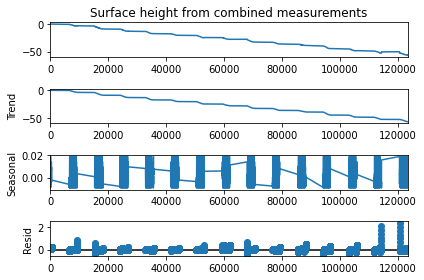

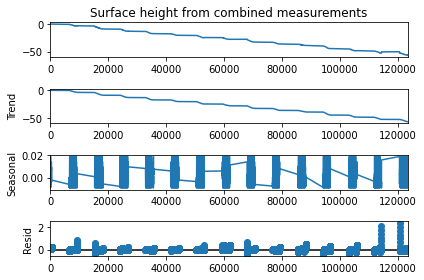

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
result = seasonal_decompose(df["Surface height from combined measurements"], model="additive", period=365)

# Plot the decomposed components
result.plot()

In [25]:
# Calculate the correlation between each input variable and the trend component
corr = {}
for col in X.columns:
    corr[col] = np.corrcoef(X[col], result.trend)[0, 1]

# Sort the correlation values in descending order
corr = {k: v for k, v in sorted(corr.items(), key=lambda item: abs(item[1]), reverse=True)}

# Print the correlation values
for col, c in corr.items():
    print(f"{col}: {c}")

Air pressure (upper boom): nan
Air temperature (upper boom): nan
Relative humidity (upper boom) - corrected: nan
Specific humidity (upper boom): nan
Wind speed (upper boom): nan
Wind from direction (upper boom): nan
Downwelling shortwave radiation - corrected: nan
Upwelling shortwave radiation - corrected: nan
Downwelling longwave radiation: nan
Upwelling longwave radiation: nan
Cloud cover: nan
Surface temperature: nan
Surface height 1.1: nan
year_sin: nan
year_cos: nan
month_sin: nan
month_cos: nan
day_sin: nan
day_cos: nan
hour_sin: nan
hour_cos: nan


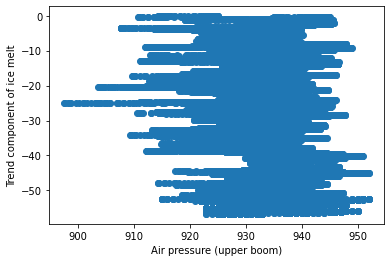

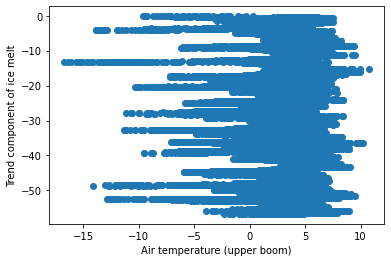

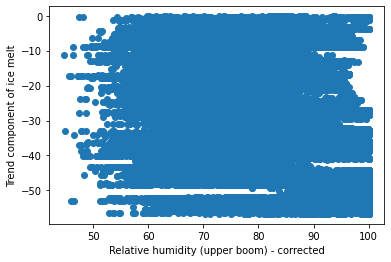

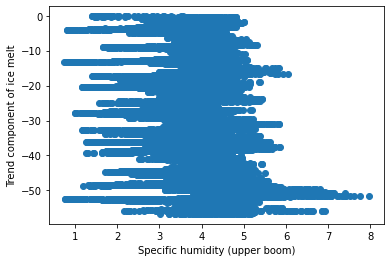

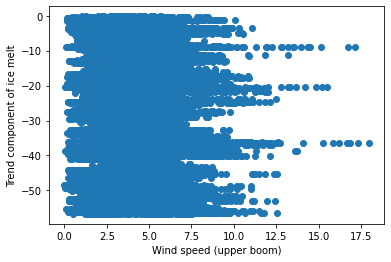

In [26]:
# Create scatter plots for the top 5 input variables
top_vars = list(corr.keys())[:5]
for var in top_vars:
    plt.scatter(X[var], result.trend)
    plt.xlabel(var)
    plt.ylabel("Trend component of ice melt")
    plt.show()